In [57]:
# GBLUP Study Setup - Population Evolution and Matrix Calculations
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Import chewc components
from chewc.population import Population, quick_haplo, combine_populations, calc_g_matrix, calc_ibd_matrix
from chewc.sp import SimParam  
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno, set_bv
from chewc.select import TruncationSelection
from chewc.cross import make_cross

# Fixed pedigree matrix function
def calc_a_matrix_pedigree_fixed(pop: Population) -> jnp.ndarray:
    """Calculate pedigree-based A-matrix with proper ID mapping."""
    n_ind = pop.nInd
    A = np.zeros((n_ind, n_ind))
    
    # Create mapping from public ID to internal index
    id_to_iid = {int(pub_id): int(iid) for pub_id, iid in zip(pop.id, pop.iid)}
    mother_ids = np.array(pop.mother)
    father_ids = np.array(pop.father)
    
    # Henderson's algorithm
    for i in range(n_ind):
        A[i, i] = 1.0
        
        dam_pub_id = mother_ids[i] if mother_ids[i] >= 0 else None
        sire_pub_id = father_ids[i] if father_ids[i] >= 0 else None
        
        dam_idx = id_to_iid.get(dam_pub_id) if dam_pub_id is not None else None
        sire_idx = id_to_iid.get(sire_pub_id) if sire_pub_id is not None else None
        
        if dam_idx is not None and sire_idx is not None:
            A[i, i] = 1.0 + 0.5 * A[dam_idx, sire_idx]
            for j in range(i):
                A[i, j] = A[j, i] = 0.5 * (A[j, dam_idx] + A[j, sire_idx])
        elif dam_idx is not None:
            for j in range(i):
                A[i, j] = A[j, i] = 0.5 * A[j, dam_idx]
        elif sire_idx is not None:
            for j in range(i):
                A[i, j] = A[j, i] = 0.5 * A[j, sire_idx]
    
    return jnp.array(A)

print("=== GBLUP Study Setup ===")

# Set random seed for reproducibility
key = jax.random.PRNGKey(42)

# ====================================================================
# 1. CREATE FOUNDER POPULATION AND SETUP
# ====================================================================
key, founder_key = jax.random.split(key)

founder_pop, gen_map = quick_haplo(
    key=founder_key, n_ind=100, n_chr=10, n_loci_per_chr=1000, 
    ploidy=2, inbred=False, chr_len_cm=100.0
)

sp = SimParam.from_founder_pop(founder_pop, gen_map)
print(f"✓ Created {founder_pop.nInd} founders with {founder_pop.geno.shape[1] * founder_pop.geno.shape[3]} SNPs")

# ====================================================================
# 2. ADD TRAIT AND SET PHENOTYPES FOR FOUNDERS
# ====================================================================
key, trait_key, pheno_key = jax.random.split(key, 3)

sp = add_trait_a(
    key=trait_key, founder_pop=founder_pop, sim_param=sp,
    n_qtl_per_chr=20, mean=jnp.array([100.0]), var=jnp.array([400.0])
)

founder_pop = set_bv(founder_pop, sp.traits, sp.ploidy)
founder_pop = set_pheno(key=pheno_key, pop=founder_pop, traits=sp.traits, 
                       ploidy=sp.ploidy, h2=jnp.array([0.3]))

print(f"✓ Added trait with {sp.traits.n_loci} QTLs, h² = {jnp.var(founder_pop.bv) / jnp.var(founder_pop.pheno):.3f}")

# ====================================================================
# 3. EVOLUTION THROUGH 3 GENERATIONS
# ====================================================================
selector = TruncationSelection()
n_parents = int(founder_pop.nInd * 0.2)  # Top 20%

# Initialize tracking
generations = []
all_populations = [founder_pop]  # Start with founders (generation 0)
current_pop = founder_pop
current_id = founder_pop.nInd

print(f"✓ Evolving through 3 generations with {n_parents} parents per generation...")

# Record founder statistics
founder_stats = {
    'generation': 0,
    'bv_mean': float(jnp.mean(founder_pop.bv)),
    'bv_std': float(jnp.std(founder_pop.bv)),
    'pheno_mean': float(jnp.mean(founder_pop.pheno)),
    'h2_realized': float(jnp.var(founder_pop.bv) / jnp.var(founder_pop.pheno))
}
generations.append(founder_stats)

# Evolution loop: create generations 1, 2, 3
for gen in range(1, 4):  # Generate offspring for generations 1, 2, 3
    print(f"Creating generation {gen}...")
    
    # Selection and mating
    key, select_key, mating_key, father_key, cross_key, pheno_key = jax.random.split(key, 6)
    
    parent_indices = selector.select_parents(key=select_key, pop=current_pop, sp=sp, n_select=n_parents)
    
    # Random mating
    n_crosses = current_pop.nInd
    mother_indices = jax.random.choice(mating_key, len(parent_indices), shape=(n_crosses,), replace=True)
    father_indices = jax.random.choice(father_key, len(parent_indices), shape=(n_crosses,), replace=True)
    
    cross_plan = jnp.column_stack([parent_indices[mother_indices], parent_indices[father_indices]])
    
    # Create offspring (initially have zeros for phenotypes and BVs)
    offspring_pop = make_cross(key=cross_key, pop=current_pop, cross_plan=cross_plan, 
                              sp=sp, next_id_start=current_id)
    
    # CRITICAL: Set breeding values and phenotypes BEFORE storing
    offspring_pop = set_bv(offspring_pop, sp.traits, sp.ploidy)
    offspring_pop = set_pheno(key=pheno_key, pop=offspring_pop, traits=sp.traits,
                             ploidy=sp.ploidy, h2=jnp.array([0.3]))
    
    # Store the completed offspring population
    all_populations.append(offspring_pop)
    
    # Record statistics
    gen_stats = {
        'generation': gen,
        'bv_mean': float(jnp.mean(offspring_pop.bv)),
        'bv_std': float(jnp.std(offspring_pop.bv)),
        'pheno_mean': float(jnp.mean(offspring_pop.pheno)),
        'h2_realized': float(jnp.var(offspring_pop.bv) / jnp.var(offspring_pop.pheno))
    }
    generations.append(gen_stats)
    
    # Update for next iteration
    current_id += offspring_pop.nInd
    current_pop = offspring_pop

print(f"✓ Evolution complete. Progress: {generations[0]['bv_mean']:.1f} → {generations[-1]['bv_mean']:.1f}")

# Verify all populations have proper phenotypes
print("\nVerifying stored populations:")
for i, pop in enumerate(all_populations):
    pheno_mean = jnp.mean(pop.pheno)
    pheno_std = jnp.std(pop.pheno)
    bv_mean = jnp.mean(pop.bv) 
    has_zeros = jnp.allclose(pop.pheno, 0.0)
    print(f"  Gen {i}: Pheno={pheno_mean:.1f}±{pheno_std:.1f}, BV={bv_mean:.1f}, zeros={has_zeros}")

# ====================================================================
# 4. CREATE MULTI-GENERATIONAL POPULATION
# ====================================================================
multi_gen_pop = all_populations[0]
for pop in all_populations[1:]:
    multi_gen_pop = combine_populations(multi_gen_pop, pop)

print(f"✓ Multi-generational population: {multi_gen_pop.nInd} individuals ({len(all_populations)} generations)")

# ====================================================================
# 5. CALCULATE RELATIONSHIP MATRICES
# ====================================================================
final_pop = all_populations[-1]  # Generation 3

# Calculate matrices
G_matrix = calc_g_matrix(final_pop.dosage)
A_ibd_matrix = calc_ibd_matrix(final_pop.ibd)

# Pedigree matrix using multi-generational data
A_ped_full = calc_a_matrix_pedigree_fixed(multi_gen_pop)
# Extract final generation subset
final_gen_start = multi_gen_pop.nInd - final_pop.nInd
final_gen_indices = jnp.arange(final_gen_start, multi_gen_pop.nInd)
A_ped_matrix = A_ped_full[jnp.ix_(final_gen_indices, final_gen_indices)]

print(f"✓ Calculated relationship matrices (all {final_pop.nInd}×{final_pop.nInd})")

# ====================================================================
# 6. SUMMARY AND VALIDATION
# ====================================================================
print("\n" + "="*50)

=== GBLUP Study Setup ===
✓ Created 100 founders with 10000 SNPs
✓ Added trait with 200 QTLs, h² = 0.239
✓ Evolving through 3 generations with 20 parents per generation...
Creating generation 1...
Creating generation 2...
Creating generation 3...
✓ Evolution complete. Progress: 56.5 → 119.9

Verifying stored populations:
  Gen 0: Pheno=103.9±40.9, BV=56.5, zeros=False
  Gen 1: Pheno=126.2±22.7, BV=83.7, zeros=False
  Gen 2: Pheno=148.4±26.1, BV=102.3, zeros=False
  Gen 3: Pheno=165.5±26.8, BV=119.9, zeros=False
✓ Multi-generational population: 400 individuals (4 generations)
✓ Calculated relationship matrices (all 100×100)



In [59]:
A_ped_matrix

Array([[1.03125 , 0.125   , 0.34375 , ..., 0.125   , 0.203125, 0.15625 ],
       [0.125   , 1.03125 , 0.09375 , ..., 0.1875  , 0.09375 , 0.015625],
       [0.34375 , 0.09375 , 1.03125 , ..., 0.28125 , 0.171875, 0.140625],
       ...,
       [0.125   , 0.1875  , 0.28125 , ..., 1.      , 0.125   , 0.046875],
       [0.203125, 0.09375 , 0.171875, ..., 0.125   , 1.0625  , 0.203125],
       [0.15625 , 0.015625, 0.140625, ..., 0.046875, 0.203125, 1.0625  ]],      dtype=float32)

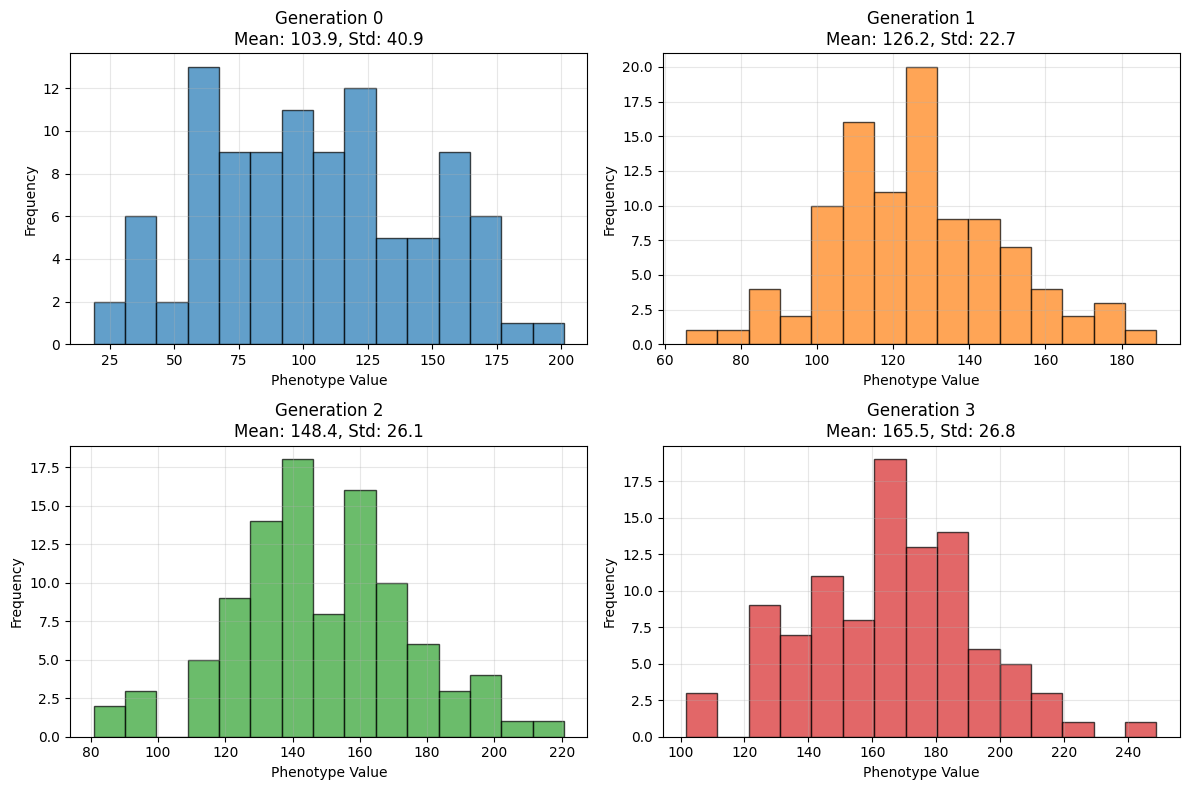

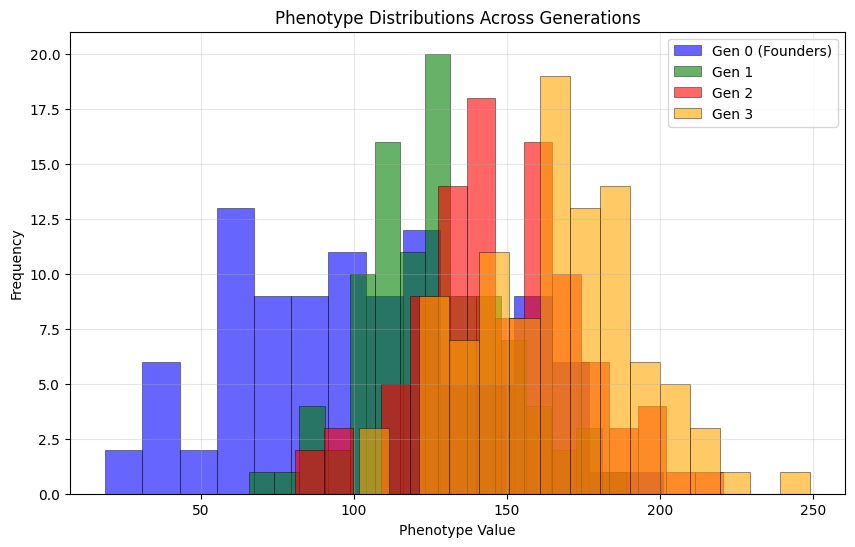

/tmp/ipykernel_3367/1870000817.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(pheno_data, labels=generation_labels)


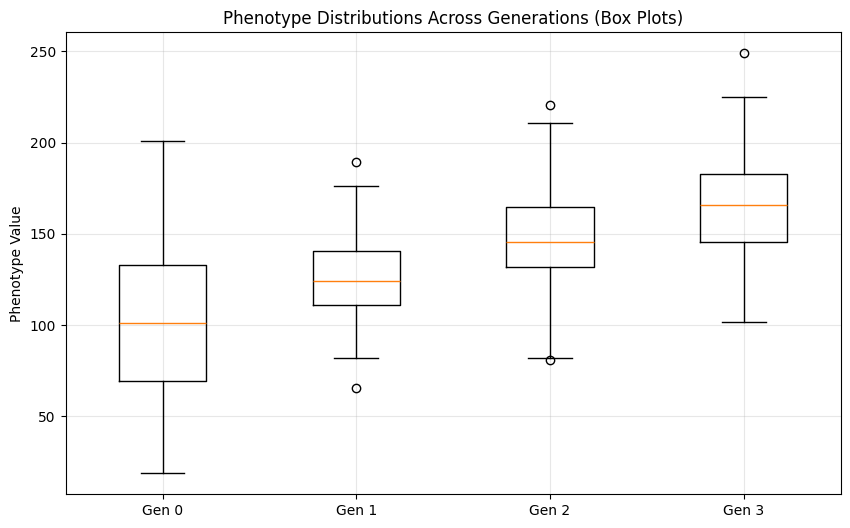

Phenotype Summary Statistics:
------------------------------------------------------------
Generation   Mean     Std      Min      Max     
------------------------------------------------------------
Gen 0         103.9    40.9     18.7     201.1   
Gen 1         126.2    22.7     65.7     189.1   
Gen 2         148.4    26.1     80.8     220.7   
Gen 3         165.5    26.8     101.7    249.0   


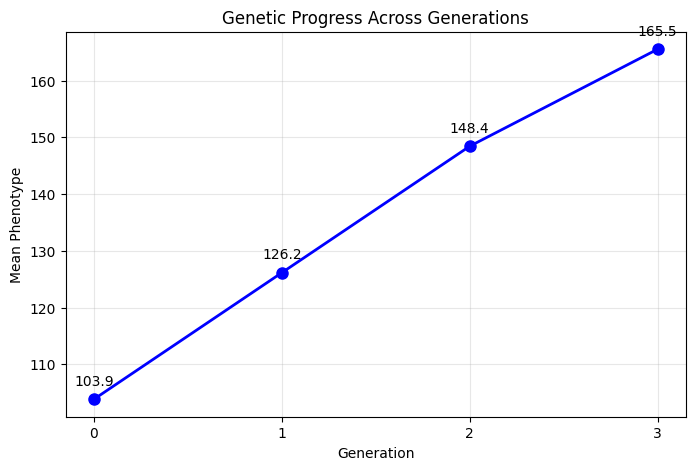

In [58]:
# Phenotype distributions across generations
import matplotlib.pyplot as plt
import numpy as np

# Method 1: Subplots for clear separation
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, pop in enumerate(all_populations):
    if i < 4:  # Only plot first 4 generations
        # Flatten the phenotype array (from shape (100,1) to (100,))
        pheno_values = pop.pheno.flatten()
        
        axes[i].hist(pheno_values, bins=15, alpha=0.7, edgecolor='black', color=f'C{i}')
        axes[i].set_title(f'Generation {i}\nMean: {np.mean(pheno_values):.1f}, Std: {np.std(pheno_values):.1f}')
        axes[i].set_xlabel('Phenotype Value')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Method 2: Overlapping histograms with transparency
plt.figure(figsize=(10, 6))

colors = ['blue', 'green', 'red', 'orange']
labels = ['Gen 0 (Founders)', 'Gen 1', 'Gen 2', 'Gen 3']

for i, pop in enumerate(all_populations):
    if i < 4:  # Only plot first 4 generations
        pheno_values = pop.pheno.flatten()
        plt.hist(pheno_values, bins=15, alpha=0.6, label=labels[i], 
                color=colors[i], edgecolor='black', linewidth=0.5)

plt.xlabel('Phenotype Value')
plt.ylabel('Frequency')
plt.title('Phenotype Distributions Across Generations')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Method 3: Box plots for comparison
plt.figure(figsize=(10, 6))

pheno_data = []
generation_labels = []

for i, pop in enumerate(all_populations):
    if i < 4:
        pheno_values = pop.pheno.flatten()
        pheno_data.append(pheno_values)
        generation_labels.append(f'Gen {i}')

plt.boxplot(pheno_data, labels=generation_labels)
plt.ylabel('Phenotype Value')
plt.title('Phenotype Distributions Across Generations (Box Plots)')
plt.grid(True, alpha=0.3)
plt.show()

# Summary statistics table
print("Phenotype Summary Statistics:")
print("-" * 60)
print(f"{'Generation':<12} {'Mean':<8} {'Std':<8} {'Min':<8} {'Max':<8}")
print("-" * 60)

for i, pop in enumerate(all_populations):
    if i < 4:
        pheno_values = pop.pheno.flatten()
        print(f"Gen {i:<9} {np.mean(pheno_values):<8.1f} {np.std(pheno_values):<8.1f} "
              f"{np.min(pheno_values):<8.1f} {np.max(pheno_values):<8.1f}")

# Genetic progress visualization
generation_means = [np.mean(pop.pheno.flatten()) for pop in all_populations[:4]]
generation_nums = list(range(4))

plt.figure(figsize=(8, 5))
plt.plot(generation_nums, generation_means, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Generation')
plt.ylabel('Mean Phenotype')
plt.title('Genetic Progress Across Generations')
plt.grid(True, alpha=0.3)
plt.xticks(generation_nums)
for i, mean in enumerate(generation_means):
    plt.annotate(f'{mean:.1f}', (i, mean), textcoords="offset points", 
                xytext=(0,10), ha='center')
plt.show()

In [25]:
G_matrix.shape

(100, 100)

In [26]:
A_ibd_matrix

Array([[0.5       , 0.06995   , 0.0477    , ..., 0.046725  , 0.19864999,
        0.048925  ],
       [0.06995   , 0.5       , 0.07045   , ..., 0.023875  , 0.070975  ,
        0.04875   ],
       [0.0477    , 0.07045   , 0.5       , ..., 0.04875   , 0.124925  ,
        0.09575   ],
       ...,
       [0.046725  , 0.023875  , 0.04875   , ..., 0.5       , 0.024125  ,
        0.02405   ],
       [0.19864999, 0.070975  , 0.124925  , ..., 0.024125  , 0.5       ,
        0.025325  ],
       [0.048925  , 0.04875   , 0.09575   , ..., 0.02405   , 0.025325  ,
        0.5       ]], dtype=float32)

In [27]:
A_ped_matrix

Array([[1.09375 , 0.078125, 0.15625 , ..., 0.078125, 0.390625, 0.09375 ],
       [0.078125, 1.0625  , 0.1875  , ..., 0.09375 , 0.109375, 0.171875],
       [0.15625 , 0.1875  , 1.0625  , ..., 0.0625  , 0.375   , 0.1875  ],
       ...,
       [0.078125, 0.09375 , 0.0625  , ..., 1.      , 0.09375 , 0.0625  ],
       [0.390625, 0.109375, 0.375   , ..., 0.09375 , 1.125   , 0.109375],
       [0.09375 , 0.171875, 0.1875  , ..., 0.0625  , 0.109375, 1.03125 ]],      dtype=float32)